# Entrenando un algoritmo de Machine Learning
---

In [1]:
# Llibrerías a utilizar
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [10]:
# Importamos el dataset
vgamesales_url = 'https://raw.githubusercontent.com/jbeltrang/datasets-ch/main/Video_Games_Sales_as_at_22_Dec_2016.csv'
vgamesales = pd.read_csv(vgamesales_url)
vgamesales

# Hacemos un dataframe trabajable y limpiamos la data que sea mayor al 2016
vgamesales_df = vgamesales
vgamesales_df = vgamesales_df.loc[vgamesales_df['Year_of_Release'] <= 2016]
vgamesales_df = vgamesales_df.dropna(subset=['Year_of_Release'])

### Dataset

---

#### Descripción del Dataset
Este dataset incluye datos de más de 100.000 videojuegos de distintas plataformas desde 1980 hasta 2016. Dentro de la data que contiene está la plataforma, año de lanzamiento, ventas totales, puntaje de crítica, desarrollado, rating, entre otros.

*Fuente:*

[Kaggle: Video Game Sales with Ratings](https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings)

#### Descripción de Variables
| Columna | Descripción |
| --- | --- |
| Rank | Ranking de las ventas promedio |
| Name | Nombre del videojuego |
| Platform | Plataforma de lanzamiento del videojuego (PC, PS4, etc.) |
| Year | Año de lanzamiento del videojuego |
| Genre | Género del videojuego |
| Publisher | Editor del videojuego |
| NA_Sales | Ventas en Norteamérica (en millones) |
| EU_Sales | Ventas en Europa (en millones) |
| JP_Sales | Ventas en Japón (en millones) |
| Other_Sales | Ventas en el resto del mundo (en millones) |
| Global_Sales | Ventas totales a nivel mundial. |
| Critic_score | Puntaje agregado del staff de Metacritic |
| Criticcount | Número de críticas usadas para obtener el puntaje del staff |
| User_score | Puntaje asignado por los suscriptores de Metacritic |
| Usercount | Número de usuarios que dieron puntaje de crítica |
| Developer | Desarrollador |
| Rating | Rating asignado por la ESRB |

In [11]:
# Tipos de variables
vgamesales_df_types = vgamesales_df.dtypes
print("Tipos de variables:\n")
print(vgamesales_df_types)

## Identificación de cantidad de NaN por columna
nan_count = vgamesales_df.isna().sum() 
print("\nNaN por columna:\n")
print(nan_count)

# Análisis Estadístico de variables numéricas

## Seleccionamos solo las columnas numéricas
vgamesales_numeric_df = vgamesales_df.select_dtypes(include=[np.number])

## Cálculo de la media por columna
mean = vgamesales_numeric_df.mean()
print("\nMedia:\n")
print(mean)

## Cálculo de la mediana por columna
median = vgamesales_numeric_df.median()
print("\nMediana:\n")
print(median)

## Cálculo de la desviación estándar por columna
standard_deviation = vgamesales_numeric_df.std()
print("\nDesviación estándar:\n")
print(standard_deviation)

## Cálculo de la varianza por columna
variance = vgamesales_numeric_df.var()
print("\nVarianza:\n")
print(variance)

## Cálculo de otros estadísticos relevantes
print("\nMínimo:\n")
print(vgamesales_numeric_df.min())

print("\nMáximo:\n")
print(vgamesales_numeric_df.max())

print("\nQuantiles:\n")
print(vgamesales_numeric_df.quantile([0.25, 0.5, 0.75]))

Tipos de variables:

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

NaN por columna:

Name                  2
Platform              0
Year_of_Release       0
Genre                 2
Publisher            32
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8463
Critic_Count       8463
User_Score         6607
User_Count         8983
Developer          6540
Rating             6678
dtype: int64

Media:

Year_of_Release    2006.484616
NA_Sales              0.264089
EU_Sales              0.145945
JP_Sales       

## Selección de Variables y Encoding

Para el caso que debemos resolver, supondremos que el género del videojuego a desarrollar en el proyecto corresponde al género de Acción. Dicho esto, procedemos a realizar la selección de variables.

In [19]:
# Definimos un subset para trabajar la selección de variables

vgamesales_set = vgamesales
# Drop de valores nulos y limpieza
vgamesales_set = vgamesales_set.dropna(subset=['Year_of_Release','Genre',"Critic_Score","User_Score"])
vgamesales_set = vgamesales_set.loc[vgamesales_set['User_Score'] != "tbd"]
# Conversión de fechas
vgamesales_set['Year_of_Release'] = pd.to_datetime(vgamesales_set['Year_of_Release'], format="%Y")
vgamesales_set['Year'] = vgamesales_set['Year_of_Release'].dt.year
# Obtener la columna de años
years = vgamesales_set['Year']
# Calcular las décadas correspondientes
decades = (years // 10) * 10
# Subset
vgamesales_set = vgamesales_set[["Platform","Year","Genre","Global_Sales","Critic_Score","User_Score"]]
# One-hot Encoding
vgamesales_set = pd.get_dummies(vgamesales_set, columns=["Platform","Genre"])
decades_encoded = pd.get_dummies(decades, prefix='Decade')
# Concatenar las columnas de décadas con el dataset original
vgamesales_set_encoded = pd.concat([vgamesales_set, decades_encoded], axis=1)
# Eliminar la columna original de "Year"
vgamesales_set_encoded.drop('Year', axis=1, inplace=True)
vgamesales_set = vgamesales_set_encoded

# Normalización de los Scores
Critic_Score_normalizado = StandardScaler().fit_transform(vgamesales_set['Critic_Score'].values.reshape(-1, 1))
User_Score_normalizado = StandardScaler().fit_transform(vgamesales_set['User_Score'].values.reshape(-1, 1))
vgamesales_set['Critic_Score'] = Critic_Score_normalizado
vgamesales_set['User_Score'] = User_Score_normalizado

vgamesales_set

,Global_Sales,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Decade_1980,Decade_1990,Decade_2000,Decade_2010
0,82.53,0.414248,0.566522,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,35.52,0.847146,0.774898,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,32.77,0.702847,0.566522,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
6,29.80,1.352194,0.913816,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,28.92,-0.884446,-0.405902,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16677,0.01,0.774997,1.122193,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
16696,0.01,0.702847,0.288686,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
16700,0.01,-0.667997,-0.961573,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
16706,0.01,-0.740146,0.010851,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


## Análisis de Correlación

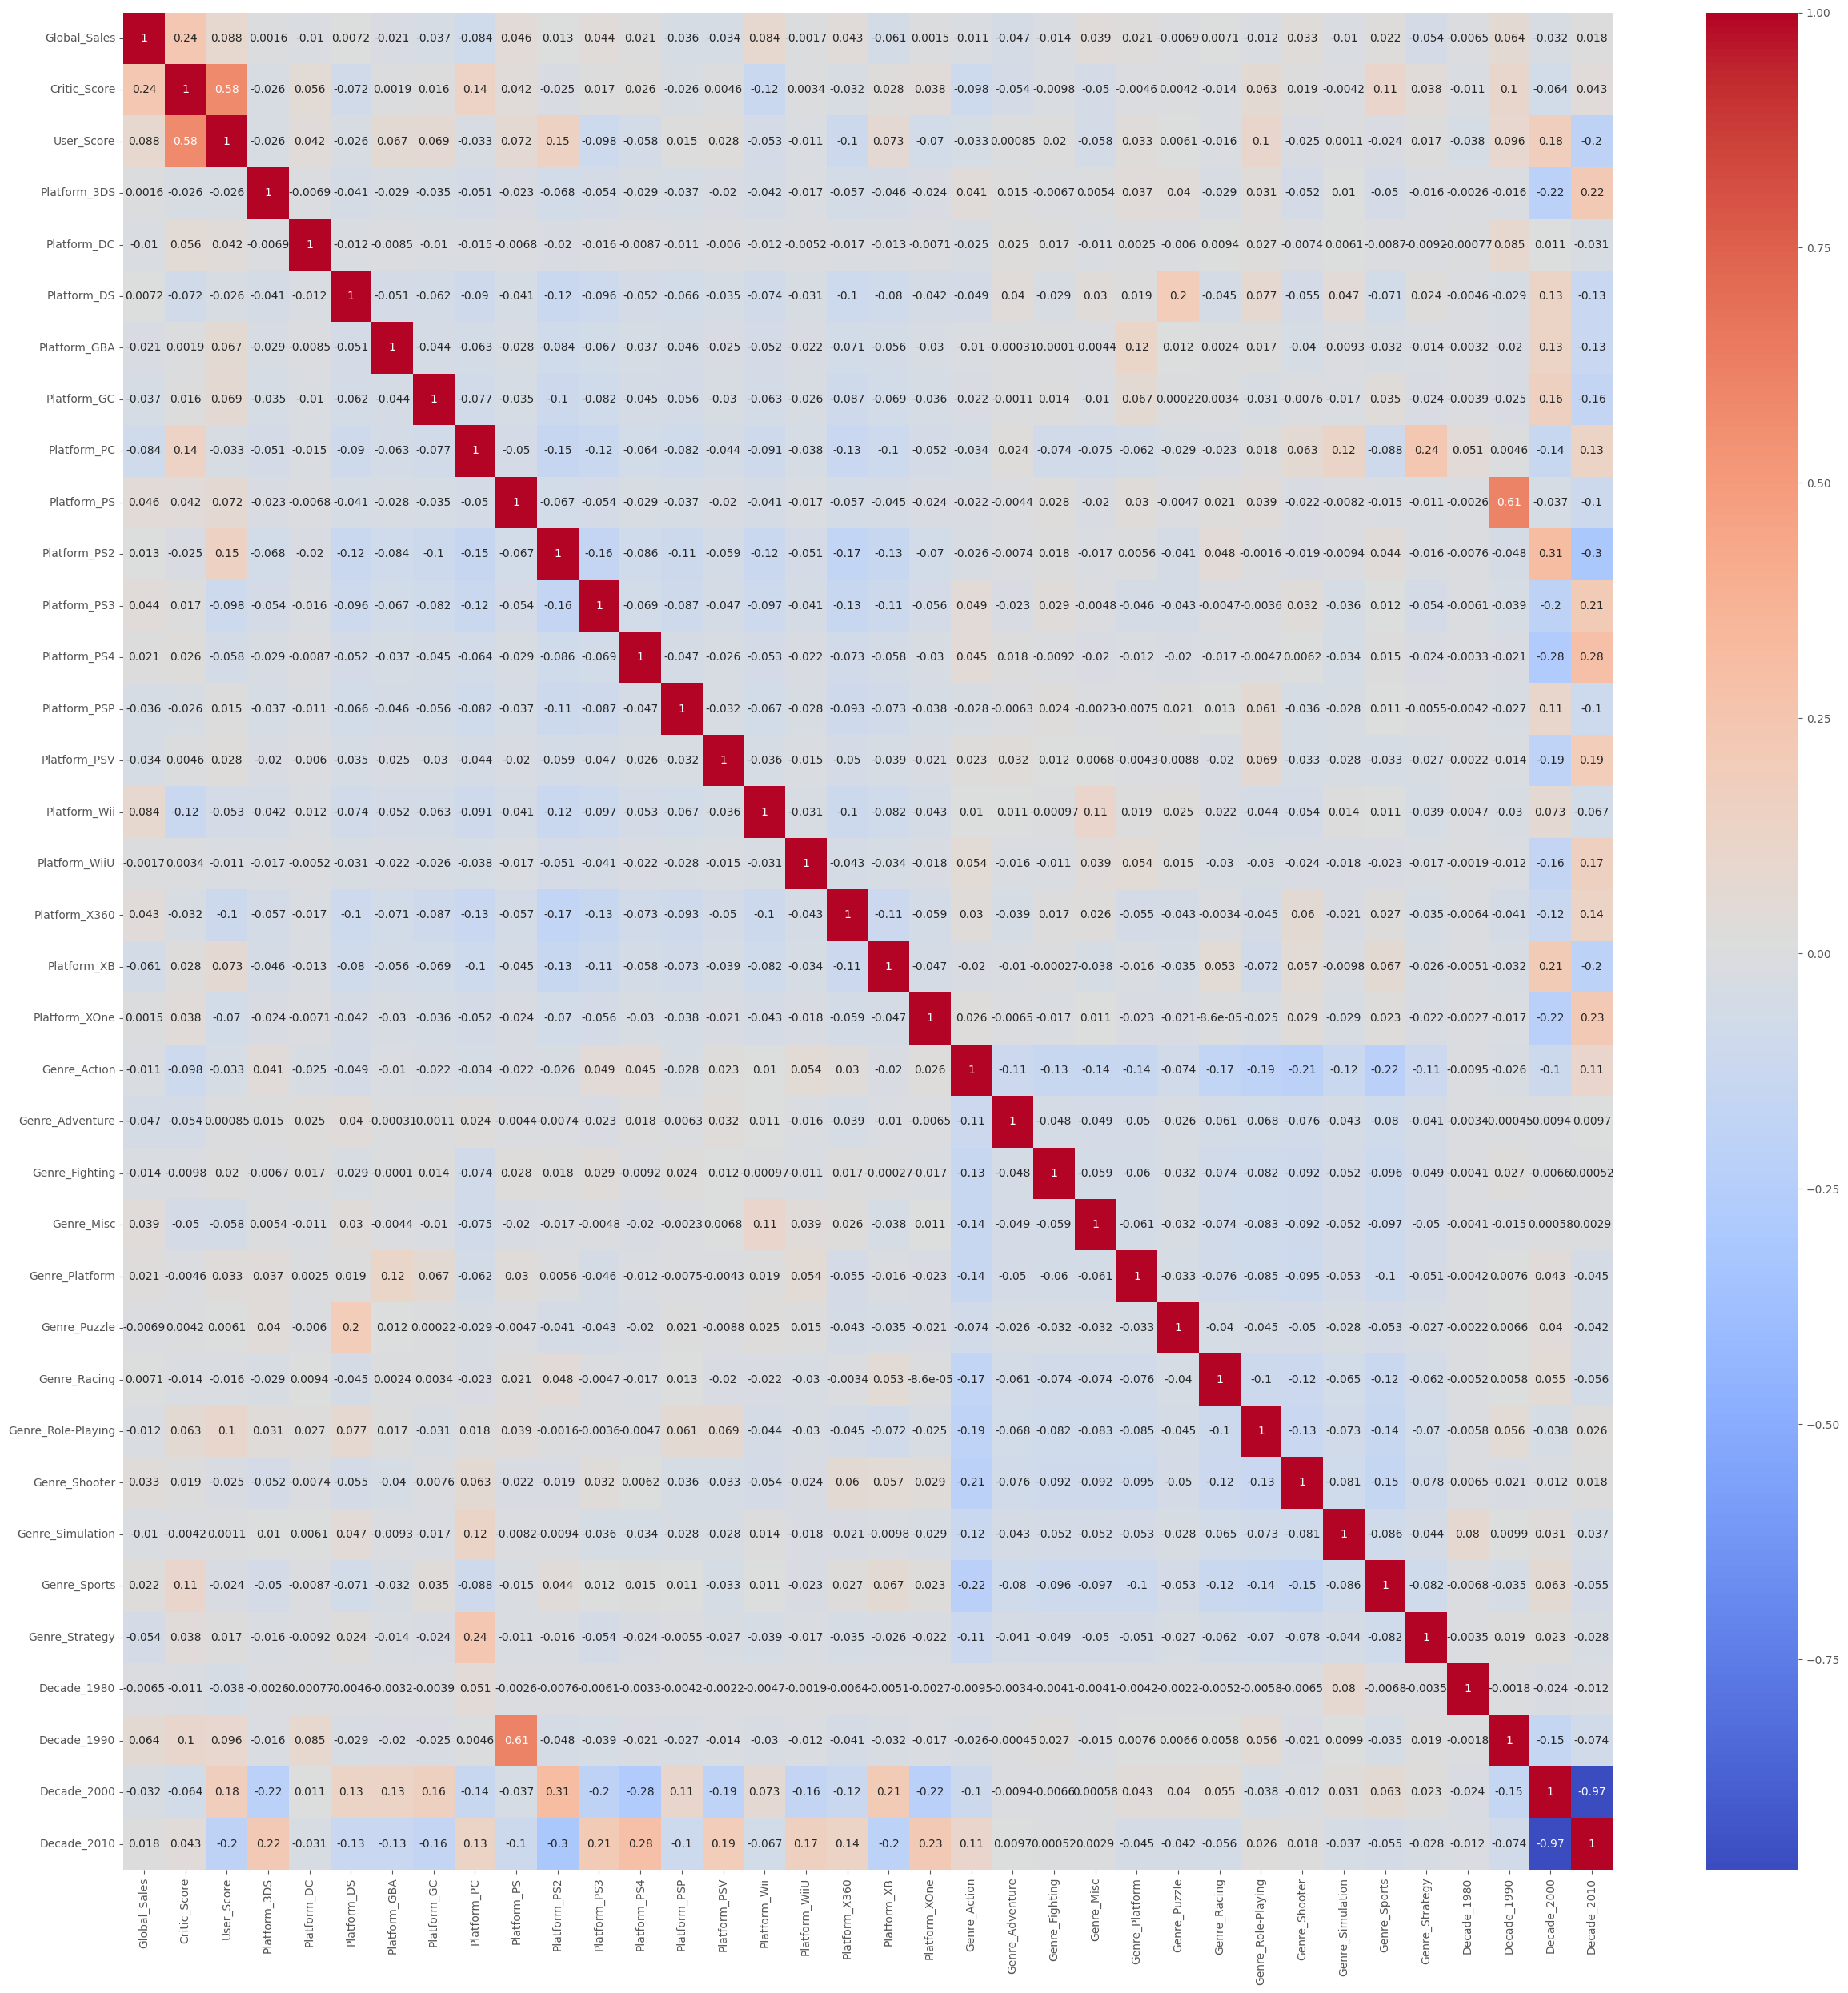

In [22]:
# Crear la matriz de correlación
correlation_matrix = vgamesales_set.corr()

# Configurar el heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Ajustar los márgenes
plt.tight_layout()

# Mostrar el Heatmap
plt.show()

## Modelamiento

In [24]:
X = vgamesales_set.drop('Global_Sales', axis=1) 
y = vgamesales_set['Global_Sales']

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
# Calcular el coeficiente de determinación (R2)
r2 = r2_score(y_test, y_pred)
print("Coeficiente de determinación (R2):", r2)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio (MSE):", mse)

# Calcular la raíz del error cuadrático medio (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Raíz del error cuadrático medio (RMSE):", rmse)

# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Error absoluto medio (MAE):", mae)

Coeficiente de determinación (R2): 0.15973894504111508
Error cuadrático medio (MSE): 2.2832897079925094
Raíz del error cuadrático medio (RMSE): 1.51105582557115
Error absoluto medio (MAE): 0.7673321187261789


## Interpretación

**Coeficiente de determinación (R2)**

El valor de R2 obtenido es 0.1597, lo que significa que aproximadamente el 16% de la variabilidad de la variable objetivo ("Global_Sales") es explicada por el modelo. Esto sugiere una reevaluación de las variables del modelo para mejorar la precisión de la predicción, lo cual puede ser guiado por la mtriz de correlación obtenida anteriormente.

**Error cuadrático medio (MSE)**

El valor de MSE obtenido es 2.2833, que representa la media de los errores al cuadrado entre las predicciones y los valores reales. Este MSE de 2.2833 indica que, en promedio, las predicciones difieren en aproximadamente 2.28 unidades al cuadrado de los valores reales.

**Raíz del error cuadrático medio (RMSE)**

El valor de RMSE obtenido es 1.5111, que es la raíz cuadrada del MSE. Al igual que el MSE, cuanto menor sea el valor de RMSE, mejor será la precisión del modelo. En este caso, un RMSE de 1.5111 indica que, en promedio, las predicciones difieren en aproximadamente 1.51 unidades de los valores reales. Si lo pensamos en términos de números, considerando que el valor mayor es 98 y el menor 0,01, las desviaciones no vendrían siendo tan grandes, lo cual es un punto positivo para la predicción.

**Error absoluto medio (MAE)**

El valor de MAE obtenido es 0.7673, que es la media de los errores absolutos entre las predicciones y los valores reales. El MAE proporciona una medida promedio del error en la misma unidad que la variable objetivo. Cuanto menor sea el valor de MAE, mejor será la precisión del modelo. En este caso, un MAE de 0.7673 indica que, en promedio, las predicciones difieren en aproximadamente 0.77 unidades de los valores reales, lo cual en términos absolutos no es tan drástico, pero si consideramos que las ventas representan millones, pasa a ser más minucioso el análisis.